Fluid-induced seismicity typically refers to (minor) seismic events that (partially) involve fluid flows. Examples range from \emph{natural} flows associated with rainfalls and volcanic eruptions to \emph{human-made} contexts including wastewater injection wells, hydraulic fracturing, and geothermal power plants. Recently, \emph{anthropogenic} sources have lead to an extraordinary surge of seismic activities in different parts of the United States \cite{ellsworth2013injection}. The most extreme cases are reported in Oklahoma and Southern Kansas where most seismic events are potentially linked to large-scale wastewater disposals. The USG survey indicates that no more than five (tectonic) earthquakes per year with magnitude  𝑚≥3  had been previously reported over almost three decades \cite{deflandre2016induced}, in sharp contrast to the one thousand  𝑚≥3  earthquakes recorded in  2016 . In this context, it is essential to identify potential anthropogenic origins and relevant secondary triggering mechanisms, which has important consequences in terms of seismic hazard assessment, earthquake forecasting and effective mitigation strategies.

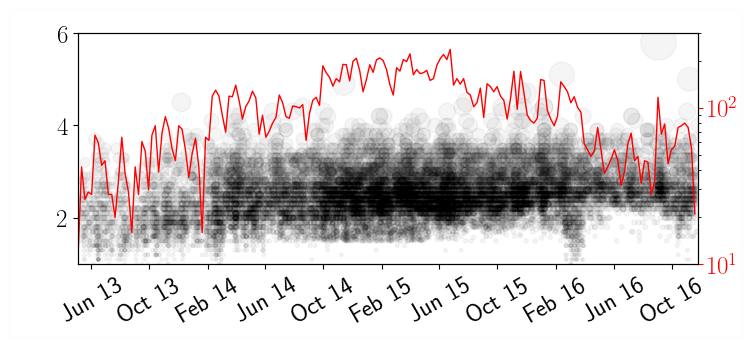

In [5]:
#--- plot complete catalog

def ConvertDailyRate(hist, bin_edges ):
#---convert data to daily rate     
    t0 = pd.to_datetime( bin_edges[ 0 ] )
    t1 = pd.to_datetime( bin_edges[ 1 ] )
    delta_t = ( t1 - t0 ).total_seconds() / ( 60 * 60 * 24 * 7)
    hist *= ( bin_edges[ 1 ] - bin_edges[ 0 ] ) / delta_t

def ActivityRate( swarm ):
    nbins = int( (swarm['date'].max()-swarm['date'].min()).days / 7 ) #--- number of bins
    
    tmax = swarm['date'].max().value #--- min/max
    tmin = swarm['date'].min().value
    
    hist, bin_edges = np.histogram(swarm['date'].apply(lambda x:x.value),                                   
                    bins=np.linspace(tmin,tmax,nbins+1,endpoint=True),density=True) #--- probability dist.
    hist *= len( swarm['date'] ) #--- int(hist).dt=n
    cumm_number = np.cumsum(hist)*(bin_edges[1]-bin_edges[0]) #--- accumulated number
    ConvertDailyRate( hist, bin_edges ) #--- daily activity
    return bin_edges, hist, cumm_number
    
    
#---------------------------------------------------------------------------------
#-----------------
#-----------------
#-----------------
#---------------------------------------------------------------------------------
   
#--- completeness
mc = 2.8



#--- t0<t<t1
#--- set min/max time to avoid temporal incompletenesss issue
swarm_tmp = swarm.copy()#DataFrameSubSet( swarm, 
                         #    'date', 
                          #   ( swarm['date'].min(), 
                           #    pd.to_datetime('2010-07-31') ) )
#--- m > mc
swarm_lohi = swarm_tmp.copy() #DataFrameSubSet( swarm_tmp, 
                            # 'magnitude', 
                             #( mc, sys.maxint ) ) 

#--- spatial map
#swarm_lohi.plot.scatter('longitude','latitude',
#                        s=3**(swarm_lohi['magnitude']),
#                        c='date',cmap='jet',
#                        alpha = 0.4) #--- plot
    
#--- temporal map
fig = plt.figure(figsize=(8,3))#,dpi=150)
ax1=fig.add_subplot(111)

#plt.xlabel('Time')
#plt.ylabel('M')

ax1.set_ylim(1,6)
ax1.set_xlim(swarm_tmp['date'].min(),swarm_tmp['date'].max())

ax1.tick_params(axis='both',labelsize=18)
ax1.tick_params(axis='x',rotation=30)

ax1.scatter(swarm_lohi['date'],swarm_lohi['magnitude'],
            s=2*np.exp(swarm_lohi['magnitude']),
            alpha=0.04,color='black')

DrawFrame(ax1, (0.11,0.07),(0.32,0.1),0.01)

#--- activity rate
bin_edges, hist, cumm_number = ActivityRate( swarm_lohi )

#--- plot
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(pd.to_datetime(bin_edges[:-1]),hist,'r-',linewidth=1)

ax2.tick_params(axis='y',labelsize=18,colors='red')

ax2.set_yscale('log')

ax2.set_ylim(1e1,3e2)

ax2.xaxis.set_major_formatter(dates.DateFormatter('%b %y'))

#fig.autofmt_xdate(bottom=.1)

fig.savefig('%s/timeSeries_ok.png'%DIR_OUTPT_figs,dpi=150,bbox_inches='tight',transparent=True)


In [3]:
#--- extract the catalog

import pandas as pd
#import matplotlib; matplotlib.use('agg')
import sys
from matplotlib import rc
import matplotlib
import matplotlib.pylab as plt
import numpy as np
from matplotlib import patches
import warnings
import matplotlib.ticker
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import datetime
#import path
from math import *
import matplotlib.dates as mdates
from matplotlib import dates
import matplotlib.dates as md
import matplotlib.cm as cm
from matplotlib.font_manager import FontProperties
import itertools
import traceback
from scipy.ndimage import gaussian_filter
import math

mpl.rcParams.update(mpl.rcParamsDefault)
warnings.filterwarnings('ignore') #--- get rid of warnings

rc('text', usetex=True)
font = {'size'   : 20}
matplotlib.rc('font', **font)

def DrawFrame(ax, (alpha_xl,alpha_xr),(alpha_yb,alpha_yt),linewidth,LOG_X=None,LOG_Y=None):
    [xlo,xhi,ylo,yhi] = ax.axis()
    if LOG_X:
        [xlo,xhi,junk,junk] = np.log10(ax.axis())
    if LOG_Y:
        [junk,junk,ylo,yhi] = np.log10(ax.axis())
    lx = xhi - xlo
    ly = yhi - ylo
    xy = [xlo - alpha_xl * lx, ylo - alpha_yb * ly]
    height = ly*(1+alpha_yb+alpha_yt)
    width = lx*(1+alpha_xl+alpha_xr)
    xy_end=[xy[0]+width,xy[1]+height]
    if LOG_X:
        xy[0] = 10 ** xy[0]
        xy_end[0] = 10 ** xy_end[0]
    if LOG_Y:
        xy[1] = 10 ** xy[1]
        xy_end[1] = 10 ** xy_end[1]
    ax.add_patch( patches.Rectangle(xy=xy, width=xy_end[0]-xy[0], 
                                    height=xy_end[1]-xy[1], linewidth=linewidth,
                                    clip_on=False,facecolor=None,edgecolor='black',fill=None) ) 
    
#--- add a new time attribute
def ConvertTime( df_in ):
    df=df_in.copy()
    df.insert(0,'date',pd.to_datetime(swarm[['year', 'month', 'day', 'hour', 'minute', 'second']]))
    df.drop(['year', 'month', 'day', 'hour', 'minute', 'second'],axis=1,inplace=True)
    return df

#--- set path
SWARM_PATH = './dataset/Oklahoma/TableS1.csv' #sys.argv[1]
DIR_OUTPT = './dataset/Oklahoma' #sys.argv[2]
DIR_OUTPT_figs = '/Users/Home/Desktop/Tmp/txt' #'/Users/Home/Dropbox/Documents/papers/microSeismicityOklahoma/figs'

#--- store
swarm = pd.read_csv( SWARM_PATH, sep = ',' ) #--- parse data

swarm = ConvertTime( swarm ) #--- add new column 'date'

#--- sort based on time
swarm.sort_values(by=['date'],inplace=True)

#--- reindex
swarm.reset_index(inplace=True,drop=True)

#--- rename cols
swarm = swarm.rename(index=str,columns={'lat':'latitude','lon':'longitude','mag':'magnitude'})

swarm.head()

,date,eventid,latitude,longitude,depth,magnitude,mag_label,dmin,gap,abs_err_h,...,rel_err_h,rel_err_z,rms,nctp,ncts,rms_ct,nccp,nccs,rms_cc,other_id
0,2013-05-05 05:45:50.610,1,35.606586,-97.261084,5.228,2.2,ML,28,247,1.88,...,25.291987,36.194237,0.02,69,80,0.071,12,14,0.003,ogs8714
1,2013-05-05 15:35:08.990,2,35.663400,-97.117599,4.191,2.3,ML,41,239,0.71,...,51.445586,88.536059,0.02,140,147,0.067,0,0,-9.000,ogs8575
2,2013-05-06 23:49:41.220,3,35.578798,-97.298077,3.899,1.9,ML,23,238,1.71,...,46.958145,95.760631,0.03,121,113,0.072,0,0,-9.000,ogs8558
3,2013-05-07 01:24:01.010,4,35.559407,-97.300820,4.577,1.8,ML,28,311,1.36,...,323.613127,504.077479,0.03,76,132,0.087,0,0,-9.000,ogs8672
4,2013-05-07 07:46:07.510,5,35.542460,-97.153658,4.717,2.2,ML,30,248,0.66,...,602.014703,1535.566696,0.02,85,65,0.120,0,0,-9.000,ogs8600
